In [89]:
import my_functions as my
%pylab inline

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator(interval=1)  # every month
weeks = mdates.WeekdayLocator(byweekday=mdates.MO, interval=3)
week = mdates.WeekdayLocator(byweekday=mdates.MO, interval=1)
yearsFmt = mdates.DateFormatter("%d/%m")

import glidertools as gt
import xarray as xr
import numpy as np
import pandas as pd

import cmocean.cm as cmo

matplotlib.rcParams['figure.figsize'] = (18,10)
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.direction'] = 'in'

font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 12}

matplotlib.rc('font', **font)

matplotlib.rc('ytick.major', size=4)
matplotlib.rc('xtick.major', size=4)
matplotlib.rc('ytick.minor', size=4)
matplotlib.rc('xtick.minor', size=4)
matplotlib.rc('lines', linewidth=1.5)

Populating the interactive namespace from numpy and matplotlib


/Users/marcel/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['var']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


#### Load the glider data

In [4]:
interp_res = '6H'
offset     = '3H'
dt=21600

# dat_saz = xr.open_dataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/sg542_saz_L2.nc')
# dat_apz = xr.open_dataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/slocum_apz_L2.nc')
# dat_miz = xr.open_dataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/sg643_miz_L2.nc')

# dat_saz_interp = dat_saz.resample(time=interp_res, loffset=offset).mean()
# dat_apz_interp = dat_apz.resample(time=interp_res, loffset=offset).mean()
# dat_miz_interp = dat_miz.resample(time=interp_res, loffset=offset).mean()

# dat_saz_interp=dat_saz_interp.interpolate_na(dim='time')
# dat_apz_interp=dat_apz_interp.interpolate_na(dim='time')
# dat_miz_interp=dat_miz_interp.interpolate_na(dim='time')

In [5]:
dat_saz = xr.open_dataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/dat_saz_L3.nc')
dat_apz = xr.open_dataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/dat_apz_L3.nc')
dat_miz = xr.open_dataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/dat_miz_L3.nc')

#### Load ERA5

In [6]:
import my_functions as my

era5 = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/ERA5_flux_data/*.nc')
era5 = era5.sel(latitude=slice(-40, -65), longitude=slice(-30, 30))

# convert from J m-2 to W m-2
var_name=['slhf', 'sshf', 'str', 'ssr', 'tp', 'e']
era5=my.convert_era5_to_Wm2(ds=era5, var_name=var_name)

# calculate net fluxes and emp
era5['emp']  = (('time', 'latitude', 'longitude'), era5['e']-era5['tp'])
era5['qnet'] = (('time', 'latitude', 'longitude'), era5['slhf']+era5['sshf']+era5['str']+era5['ssr'])

# interp to the resolution of the glider
era5_interp = era5.resample(time=interp_res, loffset=offset).mean()

#### Load JRA55

In [7]:
ep_jra55 = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/precipitation_evaporation/JRA55/*.nc')
hf_jra55 = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/heat_flux/JRA55/*.nc')
ws_jra55 = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/wind_speed/JRA55/*.nc')

# merge the datasets
jra55 = xr.merge([ep_jra55, hf_jra55, ws_jra55])

# correct the longitudes
jra55 = my.adjust_lon_xr_dataset(jra55, lon_name='g4_lon_2')

# Change to consisent naming convention for longitude and latitudes
jra55 = jra55.rename({'g4_lat_1'           : 'latitude',
                      'g4_lon_2'           : 'longitude',
                      'initial_time0_hours': 'time'})

# rename variables
jra55 = jra55.rename({
                      'LHTFL_GDS4_SFC_ave3h': 'slhf',
                      'SHTFL_GDS4_SFC_ave3h': 'sshf',
                      'DSWRF_GDS4_SFC_ave3h': 'dssr',
                      'USWRF_GDS4_SFC_ave3h': 'ussr',
                      'DLWRF_GDS4_SFC_ave3h': 'dstr',
                      'ULWRF_GDS4_SFC_ave3h': 'ustr',
                      'EVP_GDS4_SFC_ave3h'  : 'e',
                      'TPRAT_GDS4_SFC_ave3h': 'tp',
                      'UGRD_GDS4_HTGL'      : 'u10',
                      'VGRD_GDS4_HTGL'      : 'v10',})

jra55 = jra55.sel(latitude=slice(-40, -65), longitude=slice(-30, 30))

jra55['e']  = (('time', 'latitude', 'longitude'), -jra55['e']/(86400*1000))
jra55['tp'] = (('time', 'latitude', 'longitude'),  jra55['tp']/(86400*1000))

jra55['ssr'] = (('time', 'latitude', 'longitude'),  jra55['dssr']-jra55['ussr'])
jra55['str'] = (('time', 'latitude', 'longitude'),  jra55['dstr']-jra55['ustr'])

jra55['sshf'] = (('time', 'latitude', 'longitude'),  -jra55['sshf'])
jra55['slhf'] = (('time', 'latitude', 'longitude'),  -jra55['slhf'])

# calculate net fluxes and emp
jra55['emp']  = (('time', 'latitude', 'longitude'), jra55['e']   -jra55['tp'])
jra55['qnet'] = (('time', 'latitude', 'longitude'), jra55['slhf']+jra55['sshf']+jra55['str']+jra55['ssr'])

# interp to the resolution of the glider
jra55_interp = jra55.resample(time=interp_res, loffset=offset).mean()

#### Load MERRA2

In [8]:
ep_merra = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/precipitation_evaporation/MERRA2/*.nc4')
hf_merra = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/heat_flux/MERRA2/*.nc4')
ws_merra = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/wind_speed/MERRA2/*.nc4')

# merge the datasets
merra = xr.merge([ep_merra, hf_merra, ws_merra])
merra = merra.sel(lat=slice(-65, -40), lon=slice(-30, 30))

# correct the longitudes
merra = my.adjust_lon_xr_dataset(merra, lon_name='lon')

# Change to consisent naming convention for longitude and latitudes
merra = merra.rename({'lat': 'latitude',
                    'lon': 'longitude'})

# rename variables
merra = merra.rename({
                    'EFLUX'  : 'slhf',
                    'HFLUX'  : 'sshf',
                    'SWGNT'  : 'ssr',
                    'LWGNT'  : 'str',
                    'EVAP'   : 'e',
                    'PRECTOT': 'tp',
                    'U10M'   : 'u10',
                    'V10M'   : 'v10'})

merra['e']  = (('time', 'latitude', 'longitude'), -merra['e']/(1025))
merra['tp']  = (('time', 'latitude', 'longitude'), merra['tp']/(1025))

merra['sshf'] = (('time', 'latitude', 'longitude'),  -merra['sshf'])
merra['slhf'] = (('time', 'latitude', 'longitude'),  -merra['slhf'])

# calculate net fluxes and emp
merra['emp']  = (('time', 'latitude', 'longitude'), merra['e']   -merra['tp'])
merra['qnet'] = (('time', 'latitude', 'longitude'), merra['slhf']+merra['sshf']+merra['str']+merra['ssr'])

# interp to the resolution of the glider
merra_interp = merra.resample(time=interp_res, loffset=offset).mean()

In [9]:
# interpolate to the nearest location of the glider
from tqdm import tqdm

var_name = ['slhf','sshf','str' ,'ssr' ,'tp' ,'e' ,'emp' , 'u10', 'v10', 'qnet']

for var in tqdm(var_name):
  
    dat_saz[var+'_era5'] = (('time'), my.interp_glider_era5(dat_saz, era5_interp, var=var))
    dat_apz[var+'_era5'] = (('time'), my.interp_glider_era5(dat_apz, era5_interp, var=var))
    dat_miz[var+'_era5'] = (('time'), my.interp_glider_era5(dat_miz, era5_interp, var=var))
    
    dat_saz[var+'_merra'] = (('time'), my.interp_glider_era5(dat_saz, merra_interp, var=var))
    dat_apz[var+'_merra'] = (('time'), my.interp_glider_era5(dat_apz, merra_interp, var=var))
    dat_miz[var+'_merra'] = (('time'), my.interp_glider_era5(dat_miz, merra_interp, var=var))
    
    dat_saz[var+'_jra55'] = (('time'), my.interp_glider_era5(dat_saz, jra55_interp, var=var))
    dat_apz[var+'_jra55'] = (('time'), my.interp_glider_era5(dat_apz, jra55_interp, var=var))
    dat_miz[var+'_jra55'] = (('time'), my.interp_glider_era5(dat_miz, jra55_interp, var=var))

100%|██████████| 10/10 [22:49<00:00, 136.98s/it]


In [41]:
import airsea

In [42]:
for r, dat in enumerate([dat_saz_1D, dat_apz_1D, dat_miz_1D]):
    
    dat['tau_merra'] = airsea.windstress.stress(np.sqrt(dat['u10_merra']**2 + dat['v10_merra']**2), z=10., drag='largepond')
    dat['tau_jra55'] = airsea.windstress.stress(np.sqrt(dat['u10_jra55']**2 + dat['v10_jra55']**2), z=10., drag='largepond')
    dat['tau_era5']  = airsea.windstress.stress(np.sqrt(dat['u10_era5'] **2 + dat['v10_era5'] **2), z=10., drag='largepond')

### Figure compare

In [35]:
dat_saz_1D = dat_saz.resample(time='1D').mean()
dat_apz_1D = dat_apz.resample(time='1D').mean()
dat_miz_1D = dat_miz.resample(time='1D').mean()

In [98]:
print('jra-era:   ' + str(np.sqrt((dat_saz_1D['qnet_jra55']-dat_saz_1D['qnet_era5']) **2).mean().values))
print('jra-merra: ' + str(np.sqrt((dat_saz_1D['qnet_jra55']-dat_saz_1D['qnet_merra'])**2).mean().values))
print('era-merra: ' + str(np.sqrt((dat_saz_1D['qnet_era5'] -dat_saz_1D['qnet_merra'])**2).mean().values))

jra-era:   32.858651309058715
jra-merra: 43.75588768698302
era-merra: 45.190537226232955


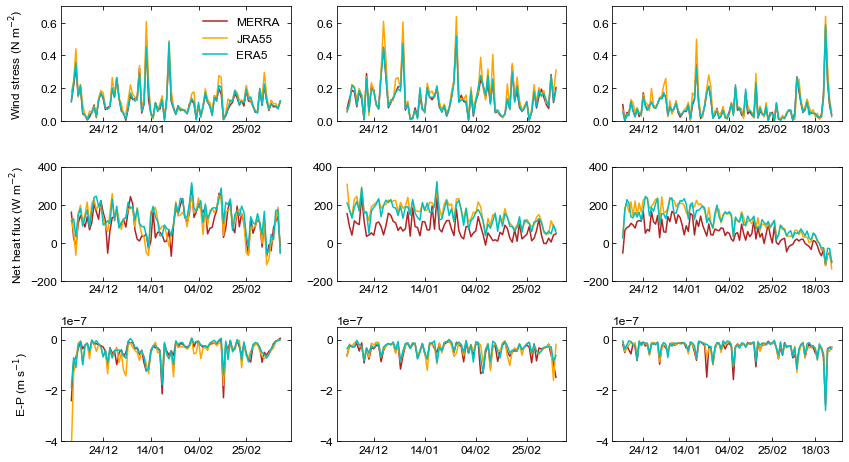

In [91]:
fig,ax=subplots(3,3, figsize=[14, 8]) 
fig.subplots_adjust(hspace=0.4)

for r, dat in enumerate([dat_saz_1D, dat_apz_1D, dat_miz_1D]):
    
    for c, var in enumerate(['tau', 'qnet', 'emp']):
        
        ax[c, r].plot(dat.time.values, dat[var+'_merra'], label='MERRA', c='firebrick')
        ax[c, r].plot(dat.time.values, dat[var+'_jra55'], label='JRA55', c='orange')
        ax[c, r].plot(dat.time.values, dat[var+'_era5'] , label='ERA5', c='c')
        
        ax[0, c].set_ylim(0, 0.7)
        ax[1, c].set_ylim(-200, 400)
        ax[2, c].set_ylim(-4e-7, 0.5e-7)
        
        ax[r,c].xaxis.set_major_locator(weeks)
        ax[r,c].xaxis.set_major_formatter(yearsFmt)

        ax[r,c].yaxis.set_ticks_position('both')
        ax[r,c].xaxis.set_ticks_position('both')
        
ax[0,0].legend(frameon=False)

# ylabels
ax[0,0].set_ylabel('Wind stress (N m$^{-2}$)', labelpad=15)
ax[1,0].set_ylabel('Net heat flux (W m$^{-2}$)')
ax[2,0].set_ylabel('E-P (m s$^{-1}$)', labelpad=13)

savefig('../../figures/Final Figures/Fig_S1_reanalysis_comparisons_colocated.png', dpi=300)